# Test CNN Model

In [1]:
import os
os.chdir("..")
!pwd
!pyenv version
%load_ext autoreload
%autoreload 2

/Users/loicmorel/code/projetcs/crypto_assistant
crypto_assistant (set by PYENV_VERSION environment variable)


In [2]:
import pandas as pd
import numpy as np
from app.data_mgt.datamgt import ohlcv_from_csv_to_df
from tqdm import trange
from scipy import stats
from datetime import datetime
from app.modeling.utils import adding_target_to_data
from app.indicators import find_swings
from app.indicators import classify_swings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from datetime import datetime
from app.config import Config
from pyts.image import GramianAngularField
from app.modeling.mlflow_tooling import Mlflow
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

## Model class

In [14]:
# run me...
class CNNModel():
    def __init__(self, params):
        self.params = params
        self.config = Config()
        self.model = 'null'

    def X_y_construct(self,data):
        self.data = data
        print('construction of X and y for',
              self.params['metadata']['symbol'],
              self.params['model_name'],
              self.params['metadata']['frequency'])

        self.data['gaf'] = data[::-1].apply(
            lambda r: self._generate_gaf_images_from_ohlc(
                self.data, self.params, r.name+1), axis=1
        )
        self.data = self.data.dropna().reset_index().drop(columns='index')

        X = []
        y = []

        for gaf_meta in self.data.gaf:
            X.append(gaf_meta['img'])
        X = np.array(X)
        y = self.data[self.params['target']]
        y = np.array(y)

        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(X, y, test_size=0.33, random_state=42)

        print(self.X_train.shape, self.y_train.shape)
        
        return self.data

    def model_compile(self):
        self.model = models.Sequential()

        # Conv1
        self.model.add(layers.Conv2D(16, (4, 4), input_shape=self.X_train.shape[1:], padding='same', strides=(1, 1)))
        self.model.add(layers.Activation('sigmoid'))

        # Conv2
        self.model.add(layers.Conv2D(16, (4, 4), padding='same', strides=(1, 1)))
        self.model.add(layers.Activation('sigmoid'))

        # FC
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(128, activation='relu'))
        self.model.add(layers.Dropout(0.3))

        self.model.add(layers.Dense(self.y_train.shape[1],activation='softmax'))

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=self.params['lr']),
            metrics=['accuracy']
        )

        print(self.model.summary())

    def model_fitting(self):
        class_weight = {
            0: 6,
            1: 6,
            2: 6,
            3: 6,
            4: 1.
        }

        #es=EarlyStopping(monitor='accuracy', patience=self.params['patience'])

        self.hist = self.model.fit(
            x=self.X_train, y=self.y_train,
            validation_split=0.2,
            batch_size=self.params['batch_size'],
            epochs=self.params['epochs'],
            verbose=2,
            #callbacks = [es],
            class_weight=class_weight
        )

        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        print('loss:', loss, 'accuracy:', accuracy)

        # log to MLFlow
        self._track_on_mlf()
        self.mlf_client.log_param("name", self.params['model_name'])
        self.mlf_client.log_param("symbol", self.params['metadata']['symbol'])
        self.mlf_client.log_param("lr", self.params['lr'])
        self.mlf_client.log_param("epochs", self.params['epochs'])
        self.mlf_client.log_param("batch_size", self.params['batch_size'])
        # self.mlf_client.log_param("patience", self.params['patience'])

        self.mlf_client.log_metric("loss", loss)
        self.mlf_client.log_metric("accuracy", accuracy)

    def model_saving(self):
        
        model_file = f"model_{CNN_model_params['model_name']}_{metadata['symbol']}_"\
                     f"{metadata['frequency']}_{metadata['start_ts']}_"\
                     f"{metadata['end_ts']}_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.h5"

        print('saving model:', f"{model_path}/{model_file}")
        self.model.save(f"{model_path}/{model_file}")

    def model_loading(self):

        files = [f for f in listdir(model_path) if isfile(join(model_path, f))]
        
        available_files = []
        for file in files:
            if CNN_model_params['model_name'] in file and metadata['symbol'] in file and \
                metadata['frequency'] in file and 'h5' in file:
                available_files.append(file)
        if len(available_files) == 0:
            print('model not found for:',
                model_name, symbol, frequency)
            return 'null'
        model_file = sorted([file for file in available_files])[-1]
        
        #print('loading model:', f"{model_path}/{model_file}")
        self.model = models.load_model(f"{model_path}/{model_file}")
        return self.model

    def model_prediction(self, date_dt, data):

        X_pred = self._generate_gaf_images_from_ohlc(
            data,
            self.params,
            self._idx_from_dt(data, date_dt)+1
        )

        if str(X_pred) == 'nan':
            print('Error: X data cannot be constructed for CNN model')
            return -1

        pred = np.argmax(self.model.predict(np.array([X_pred['img']])))
        return self.params['target'][pred]

    def _track_on_mlf(self, **kwargs):
        ## Adding MLFlow tracking ##
        self.mlf_client = Mlflow(
            self.config.project.get('mlflow_experiment_name'),
            self.config.project.get('mlflow_uri')
        )
        self.mlf_client.create_run()
        self.mlf_client.print_url()

    def _idx_from_dt(self, data, dt):
        for index in range(0, len(data)):
            if (index+1) >= len(data) and data['o_ts'][index] >= dt:
                return index
            elif (index+1) >= len(data):
                return -1
            elif data['o_ts'][index] <= dt and data['o_ts'][index+1] > dt:
                return index
        return -1

    def _generate_gaf(self, data):
        gadf = GramianAngularField(method=CNN_model_params['gaf_encoding'], image_size=data.shape[0])
        img = gadf.fit_transform(pd.DataFrame(data).T)[0]
        return img

    def _generate_gaf_images_from_ohlc(self, data, params, idx):
        ## slicing data from the bottom of the df (reverse the time)
        ## to the top from the index provided by the lambda function

        data_slice = data[:idx][['o_ts'] + params['focus'] + params['target']]
        img = []
        ret = params.copy()

        for t in params['target']:
            if data_slice.iloc[-1][t]:
                target = t
        ret['target'] = target
        print(ret['target'])

        ## for 4x frequency to compose the gaf matrix
        for freq in params['freq']:
            data_ = data_slice.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
            data_ = data_.dropna()
            data__ = data_[::-1].reset_index().drop(columns='index')
            data___ = data__[:params['depth']]
            if data___.shape[0] < params['depth']:
                #print("data___.shape[0] < params['depth']:", data___.shape[0], params['depth'])
                return np.nan
            ret[f'start_time_{freq}'] = data___['o_ts'].iloc[0]
            ret[f'end_time_{freq}'] = data___['o_ts'].iloc[-1]
            img.append(self._generate_gaf(data___[params['focus']]))
        ret['img'] = np.array(img)
        return (ret)

    def _plot_gaf_image_matrix(self, img_np, target):
        image_matrix: tuple =(2, 2)
        fig = plt.figure(figsize=[img * 4 for img in image_matrix])
        plt.title(f'Target: {target}')
        grid = ImageGrid(fig,
                        111,
                        axes_pad=0,
                        nrows_ncols=image_matrix,
                        share_all=True,
                        )

        for ax, im in zip(grid, img_np):
            # Iterating over the grid returns the Axes.
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(im, cmap='rainbow', origin='lower')


## Access Functions

In [4]:
# run me...
def CNN_model_training(data, metadata):

    ## CNN Training
    cnn = CNNModel(CNN_model_params)
    data_t = cnn.X_y_construct(data)
    cnn.model_compile()
    cnn.model_fitting()
    cnn.model_saving()

    # test prediction
    # cnn.model_loading()
    # print(cnn.model_prediction(datetime.strptime("2022-05-10_07:00:00", "%Y-%m-%d_%H:%M:%S"), data))

    return data_t

def CNN_model_prediction(metadata, data, date):

    if date > pd.to_datetime(metadata['end_ts'], unit='ms'):
        print('Error: date not existing in the data', date)
        return -1

    ## check cached  predictions
    y_pred_cache = load_cached_pred(date,
                    CNN_model_params['model_name'],
                    CNN_model_params['metadata']['symbol'],
                    CNN_model_params['metadata']['frequency'])
    if y_pred_cache != 'null':
        #print('prediction (cached):', metadata.get('symbol'), date, y_pred_cache)
        return y_pred_cache

    ## Targets definition (merge to data df)
    data = adding_target_to_data(data)

    cnn = CNNModel(CNN_model_params)
    if cnn.model_loading():
        y_pred = cnn.model_prediction(date, data)
        # cache prediction
        cache_pred(date, y_pred,
                   CNN_model_params['model_name'],
                   CNN_model_params['metadata']['symbol'],
                   CNN_model_params['metadata']['frequency'])
        #print('prediction:', metadata.get('symbol'), date, y_pred)
        return y_pred
    else:
        return -1
    
def cache_pred(date, y_pred, model_name, symbol, frequency):

    # print('cache:', date, y_pred, model_name, symbol, frequency)
    
    file_path = search_model_offline(model_name, symbol, frequency)
    
    add_row = {}
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.DataFrame(columns=['date', 'y_pred'], dtype=object)

    add_row['date'] = date
    add_row['y_pred'] = y_pred
    df = pd.concat([df, pd.DataFrame([add_row])], axis=0, ignore_index=True)
    df.to_csv(file_path, index=False)


def load_cached_pred(date, model_name, symbol, frequency):

    # print('load cache:', date, model_name, symbol, frequency)
    
    file_path = search_model_offline(model_name, symbol, frequency)

    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)[::-1]
        y_pred = df[df['date']==str(date)]['y_pred']
        if len(y_pred) > 0:
            y_pred.values[0]
            return y_pred.values[0]
    return 'null'

def search_model_offline(model_name, symbol, frequency):

    # search offline
    files = [f for f in listdir(model_path) if isfile(join(model_path, f))]

    available_files = []
    for file in files:
        if model_name in file and symbol in file and \
            frequency in file and 'h5' in file:
            available_files.append(file)
    if len(available_files) == 0:
        print('model not found for:',
            model_name, symbol, frequency)
        return 'null'
    file = sorted([file for file in available_files])[-1]

    if file == 'null':
        return 'null'
    file_path = f'{model_path}/{os.path.splitext(file)[0]+".cache"}'
    return file_path

# Model configuration

In [10]:
data_file = 'ohlcv_ETHUSDT_1h_from_1589122800000_to_1652428800000.csv'

data_path = f"notebooks/data/"
model_path = f"notebooks/data/"

list_of_metadata = data_file.split('_')
metadata = {
    'symbol' : list_of_metadata[1],
    'frequency' : list_of_metadata[2],
    'start_ts' : list_of_metadata[4],
    'end_ts' : list_of_metadata[6].rsplit( ".", 1 )[0]
}

CNN_model_params = {
    'model_name': 'CNN',

    # data for training
    'metadata': metadata,

    # Depth of the timeframe, higher depth = bigger image.
    'depth': 40,
    # always 4x different frequency to constitute the 2x2 matrix of GAF images
    'freq': ['1h', '2h', '4h', '1d'],
    # focus on the Close price
    'focus': ['Close'],
    # sensitive to targets LL and HH
    'target': ['LL','HL','HH','LH','NP'],
    # GAF encoding: summation or difference
    'gaf_encoding': 'difference',

    # model parameters
    'lr': 0.001,
    'epochs': 50,
    'batch_size': 32,
    'patience': 20
}

print('data_file:', data_file)
print('data_path:', data_path)
print('model_path:', model_path)

data_file: ohlcv_ETHUSDT_1h_from_1589122800000_to_1652428800000.csv
data_path: notebooks/data/
model_path: notebooks/data/


## Training function

In [9]:
## Data collection
data = ohlcv_from_csv_to_df(f'{data_path}/{data_file}')

## Targets definition (merge to data df)
data = adding_target_to_data(data)

data_rnn = data.set_index('o_ts')
## Hack remove some data from the df
# data_cnn = data[-1000:-1].reset_index().drop(columns='index')
data_cnn = data.reset_index().drop(columns='index')

## 2. models trining
data_t = CNN_model_training(data_cnn, metadata)
data_t

construction of X and y for ETHUSDT CNN 1h
(11151, 4, 40, 40) (11151, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 40, 16)         10256     
_________________________________________________________________
activation (Activation)      (None, 4, 40, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 40, 16)         4112      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 40, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               327808    
_________________________________________________

2022-05-23 23:47:17.127781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/loicmorel/.pyenv/versions/3.8.12/envs/crypto_assistant/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50


2022-05-23 23:47:17.480459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


279/279 - 2s - loss: 3.4576 - accuracy: 0.6886 - val_loss: 1.2827 - val_accuracy: 0.7615
Epoch 2/50
279/279 - 2s - loss: 3.3775 - accuracy: 0.7633 - val_loss: 1.2810 - val_accuracy: 0.7615
Epoch 3/50
279/279 - 2s - loss: 3.2859 - accuracy: 0.7519 - val_loss: 1.1456 - val_accuracy: 0.7163
Epoch 4/50
279/279 - 2s - loss: 3.1035 - accuracy: 0.7111 - val_loss: 1.2393 - val_accuracy: 0.7216
Epoch 5/50
279/279 - 2s - loss: 2.8107 - accuracy: 0.5734 - val_loss: 1.0586 - val_accuracy: 0.4411
Epoch 6/50
279/279 - 2s - loss: 2.4386 - accuracy: 0.4850 - val_loss: 0.9407 - val_accuracy: 0.5325
Epoch 7/50
279/279 - 2s - loss: 2.3141 - accuracy: 0.4945 - val_loss: 0.9281 - val_accuracy: 0.5105
Epoch 8/50
279/279 - 2s - loss: 2.2285 - accuracy: 0.5206 - val_loss: 0.8111 - val_accuracy: 0.6186
Epoch 9/50
279/279 - 2s - loss: 2.1556 - accuracy: 0.5146 - val_loss: 0.8714 - val_accuracy: 0.5513
Epoch 10/50
279/279 - 2s - loss: 2.1243 - accuracy: 0.5197 - val_loss: 0.8135 - val_accuracy: 0.5930
Epoch 11/5

,o_ts,Open,High,Low,Close,Volume,LL,HL,HH,LH,NP,gaf
0,2020-06-18 00:00:00,233.82,233.83,232.93,233.51,11870.33774,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
1,2020-06-18 01:00:00,233.50,234.65,233.15,233.56,14136.03629,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
2,2020-06-18 02:00:00,233.57,233.73,232.91,233.27,15907.53114,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
3,2020-06-18 03:00:00,233.22,233.96,233.12,233.51,7414.77428,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
4,2020-06-18 04:00:00,233.55,233.74,232.73,232.84,7637.24374,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16639,2022-05-13 04:00:00,2096.46,2099.53,2070.00,2089.67,40693.22240,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16640,2022-05-13 05:00:00,2089.68,2145.00,2080.30,2107.39,69513.06870,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16641,2022-05-13 06:00:00,2107.40,2124.78,2089.02,2094.53,39037.92380,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16642,2022-05-13 07:00:00,2094.53,2096.73,2043.90,2048.16,62215.46570,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."


In [13]:
data_t

,o_ts,Open,High,Low,Close,Volume,LL,HL,HH,LH,NP,gaf
0,2020-06-18 00:00:00,233.82,233.83,232.93,233.51,11870.33774,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
1,2020-06-18 01:00:00,233.50,234.65,233.15,233.56,14136.03629,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
2,2020-06-18 02:00:00,233.57,233.73,232.91,233.27,15907.53114,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
3,2020-06-18 03:00:00,233.22,233.96,233.12,233.51,7414.77428,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
4,2020-06-18 04:00:00,233.55,233.74,232.73,232.84,7637.24374,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16639,2022-05-13 04:00:00,2096.46,2099.53,2070.00,2089.67,40693.22240,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16640,2022-05-13 05:00:00,2089.68,2145.00,2080.30,2107.39,69513.06870,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16641,2022-05-13 06:00:00,2107.40,2124.78,2089.02,2094.53,39037.92380,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."
16642,2022-05-13 07:00:00,2094.53,2096.73,2043.90,2048.16,62215.46570,0,0,0,0,1,"{'model_name': 'CNN', 'metadata': {'symbol': '..."


## Prediction function

In [23]:
train = -40 * 24

data = ohlcv_from_csv_to_df(f'{data_path}/{data_file}')
data['y_pred']='NP'
data['y_pred'][train:] = data[train:].apply(lambda r: CNN_model_prediction(metadata, data, r['o_ts']), axis=1)
# data['y_pred'] = data.apply(lambda r: CNN_model_prediction(metadata, data, r['o_ts']), axis=1)

# add HH, LL, LH, HL and NP targets to the dataframe
target_df = classify_swings(find_swings(data))
# concat databases
data = pd.concat([data, target_df], axis="columns")
data.drop(columns=[
    'c_ts',
    'CSLS',
    'Support',
    'Resistance',
    'Strong_lows',
    'Strong_highs',
    'FSL',
    'FSH',
    'Highs',
    'Lows',
    'Last',
    'Trend'], inplace=True)
data[['HH','HL','LL','LH']] = data[['HH','HL','LL','LH']] * 1
data['sum'] = data[['HH','HL','LL','LH']].sum(axis=1)
data['NP'] = data['sum'].apply(lambda x: 1 if x==0 else 0)
data.drop(columns='sum',inplace=True)
data[train:]

NP
HH
NP
HL
NP
NP
LH
NP
HL
NP
HH
NP
LL
NP
HH
NP
NP
NP
NP
LH
NP
NP
NP
NP
LH
NP
NP
NP
NP
NP
LL
NP
LH
NP
NP
NP
NP
NP
NP
NP
NP
NP
NP
LL
NP
NP
NP
LH
NP
NP
NP
NP
NP
LL
NP
NP
NP
NP
NP
HL
NP
NP
HH
NP
NP
LL
NP
NP
NP
LH
NP
HL
NP
NP
HL
NP
NP
NP
NP
HL
NP
NP
NP
HH
NP
NP
NP
LL
NP
LH
NP
NP
NP
LH
NP
NP
NP
LL
NP
LH
NP
HL
NP
HH
NP
NP
LH
NP
HL
NP
NP
HH
NP
NP
HL
NP
NP
NP
NP
NP
NP
NP
NP
NP
NP
HH
NP
NP
NP
NP
LH
NP
HL
NP
NP
LL
NP
NP
NP
NP
NP
HH
NP
NP
NP
NP
NP
NP
NP
LL
NP
NP
NP
LH
NP
NP
NP
NP
NP
NP
NP
NP
LL
NP
LH
NP
NP
NP
NP
LH
NP
NP
LL
NP
NP
NP
NP
NP
NP
HL
NP
NP
NP
HH
NP
NP
LH
NP
NP
NP
LL
NP
NP
NP
NP
HL
NP
NP
NP
HH
NP
NP
NP
NP
NP
NP
LL
NP
NP
NP
NP
HL
NP
NP
NP
NP
NP
NP
NP
NP
HH
NP
NP
NP
HL
NP
LH
NP
NP
NP
NP
NP
NP
NP
NP
NP
NP
LL
NP
NP
NP
NP
NP
HL
NP
NP
NP
LH
NP
NP
NP
NP
LH
NP
NP
LL
NP
NP
HL
NP
LH
NP
HL
NP
NP
NP
NP
HH
NP
HL
NP
LH
NP
NP
NP
LL
NP
LH
NP
NP
HH
NP
NP
NP
LL
NP
NP
NP
NP
HH
NP
NP
NP
NP
HL
NP
NP
HL
NP
NP
HL
NP
NP
NP
NP
NP
LH
NP
NP
NP
NP
NP
LH
NP
NP
NP
NP
LH
NP
NP
NP
NP
NP
LL
NP
NP
NP
NP
LH
NP
HL
NP
NP
N

/var/folders/63/jtw8zvs150d2gcdq9t06pn_m0000gn/T/ipykernel_32725/2830194038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_pred'][train:] = data[train:].apply(lambda r: CNN_model_prediction(metadata, data, r['o_ts']), axis=1)


,o_ts,Open,High,Low,Close,Volume,o_date,y_pred,LL,HL,HH,LH,NP
16605,2022-04-03 09:00:00,3475.89,3510.02,3470.20,3494.07,18777.0359,19085.375000,HH,0,0,0,0,1
16606,2022-04-03 10:00:00,3494.07,3498.46,3477.54,3484.27,12536.5068,19085.416667,NP,0,0,0,0,1
16607,2022-04-03 11:00:00,3484.27,3492.13,3472.32,3484.97,10626.3214,19085.458333,HH,0,0,1,0,0
16608,2022-04-03 12:00:00,3484.96,3508.86,3477.84,3493.34,15305.4212,19085.500000,HH,0,0,0,0,1
16609,2022-04-03 13:00:00,3493.33,3512.73,3487.44,3498.61,15708.0077,19085.541667,HL,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17560,2022-05-13 04:00:00,2096.46,2099.53,2070.00,2089.67,40693.2224,19125.166667,NP,0,0,0,0,1
17561,2022-05-13 05:00:00,2089.68,2145.00,2080.30,2107.39,69513.0687,19125.208333,NP,0,0,0,0,1
17562,2022-05-13 06:00:00,2107.40,2124.78,2089.02,2094.53,39037.9238,19125.250000,NP,0,0,0,0,1
17563,2022-05-13 07:00:00,2094.53,2096.73,2043.90,2048.16,62215.4657,19125.291667,HH,0,0,0,0,1


# Display indicators

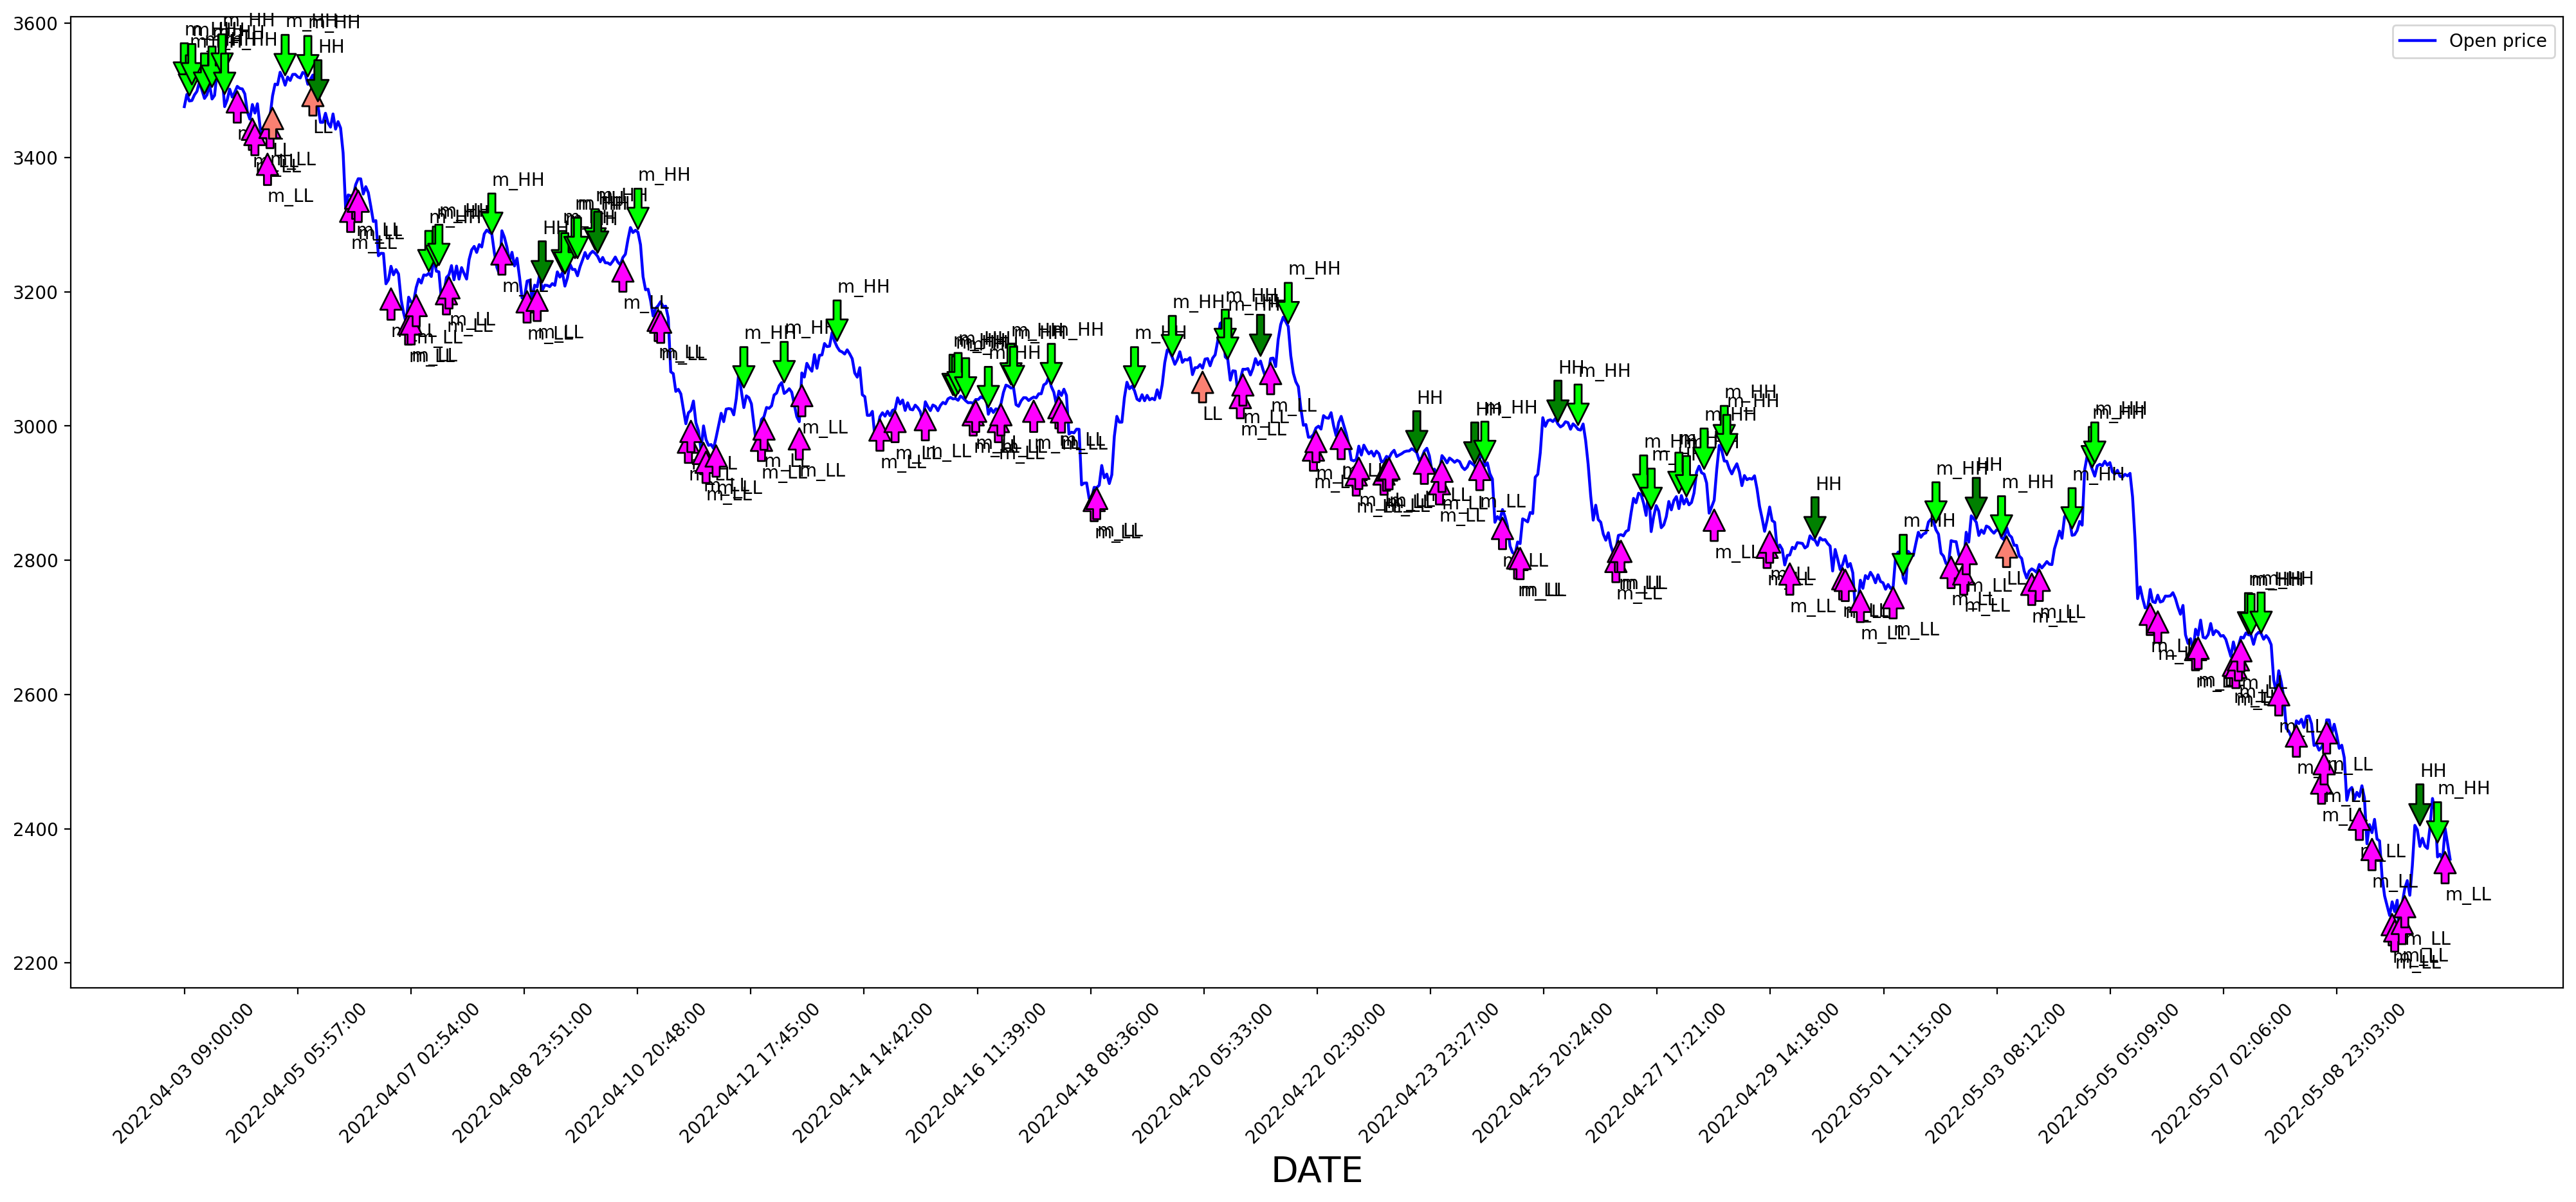

In [31]:
data_p = data[train:train+900]

fig_size = 200
fig = plt.figure(figsize=(25, 10), dpi=fig_size)

gs = gridspec.GridSpec(8, 1, wspace=0.00, hspace=0.00)  # 7x1 grid
ax = fig.add_subplot(gs[0:, 0])  # first row

data_p.plot(lw=1.6, x='o_date', y='Open', color='blue', kind='line', ax=ax, label='Open price')
# data_p.plot(lw=1.6, x='o_date', y='Close', color='green', kind='line', ax=ax, label='Close price')
g_time = data_p["o_date"].iloc[-1] - data_p["o_date"].iloc[0]
date_space = g_time / fig_size * 10
ax.xaxis.set_ticks(np.arange(data_p["o_date"].iloc[0], data_p["o_date"].iloc[-1], date_space))

ax.set_xlabel('DATE', fontsize=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.tick_params(axis='x', labelrotation=45)

### place HH, HL, LH, LL annotation
y_start, y_end = ax.get_ylim()
y_range = y_end - y_start

for index in data_p.index:
    ac_date = data_p['o_date'][index]
    if data_p['HH'][index]:
        text = 'HH'
        color = 'g'
        offset = (y_range / 20)
        y = data_p['High'][index]
    elif data_p['LL'][index]:
        text = 'LL'
        color = 'salmon'
        offset = -(y_range / 20)
        y = data_p['Low'][index]
    if data_p['y_pred'][index] == 'HH':
        text = 'm_HH'
        color = 'lime'
        offset = (y_range / 20)
        y = data_p['High'][index]
    elif data_p['y_pred'][index] == 'LL':
        text = 'm_LL'
        color = 'fuchsia'
        offset = -(y_range / 20)
        y = data_p['Low'][index]
    if data_p['HH'][index] or data_p['LL'][index] or data_p['y_pred'][index] == 'HH' or data_p['y_pred'][index] == 'LL':
        pass
        ax.annotate('{}'.format(text),
                    xy=(ac_date, y),
                    xytext=(ac_date, y + offset),
                    arrowprops=dict(facecolor=color, shrink=10))